# Interactive COVID-19 data visualizations using Python & Bokeh

### Chris Coletta
### Friday, January 29, 2021

# Goals

* Reproduce many figures from the [New York Times U.S. tracking page](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html) and other sources
    * "Epidemic curve": Cumulative cases and deaths plotted by day
    * "[Chloropleth Map](https://en.wikipedia.org/wiki/Choropleth_map)": New cases and deaths plotted by state

* Answer some important questions:
    * Maryland: What is the county-by-county situation?
    * US: Is the increase in cases coming from an increase in testing, or from actual virus spread?

# Analysis Strategy

* Use one or more of the widely available APIs that provide COVID-19 data
* Download them programmatically so figures are up to date every time you run this notebook

## NIA IRP Data Viz workshop

* Close all anaconda windows
* Open up anaconda prompt
* Run the first few cells to make sure you have everything installed
    * ```!pip install pandas-bokeh```
    * ```!pip install geopandas```
        * Requires GDAL (On Mac: ```brew install gdal```)
* RAISE YOUR HAND IN ZOOM IF YOU HAVE DONE ALL OF THE ABOVE
* The notebook we will use today is in the Zoom chat box
* Two options for running:
    * Download and run locally.
    * OR run this notebook in Google CoLab

* Workshop participants are expected to run the code along with me
* Select ```Kernel->Restart & Clear Output``` to start
* Have my presentation side-by-side with your Jupyter Notebook open
* Unmute yourself if you have questions

* Can also use Jupyterlab, but you must run additional command and restart JupyterLab
    * ```jupyter labextension install @jupyter-widgets/jupyterlab-manager```
    * ```jupyter labextension install @bokeh/jupyter_bokeh```

# What we won't cover

* Effective reproduction number
    * [rt.live](https://rt.live) - state-by-state COVID-19 transmission rate $R_t$ modelling from the makers of Instagram

* More sophisticated epidemic modelling in general
    * Please refer to John Holmes' [brilliant talk](https://videocast.nih.gov/watch=37909) AI in the Age of COVID-19: Computational Tools for a Pandemic) from yesterday: "AI in the Age of COVID-19: Computational Tools for a Pandemic"

* Information retrieval from corpus of published and pre-published scientific manuscripts adressing coronavirus

# Available Data Sources

* [NYTimes COVID-19 data on GitHub](https://github.com/nytimes/covid-19-data)
    * Cases and deaths by US County
    * Excess deaths by time series data country

* [The COVID Tracking Project](https://covidtracking.com) at The Atlantic
    * Data broken down by race and other demographic factors/social determinants

* [CSSEGISandData COVID-19 data on GitHub](https://github.com/CSSEGISandData/COVID-19)
    * COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University
    * Includes normalized case, testing, and mortality rate per 100k

* [Humanitarian Data Exchange](https://data.humdata.org/dataset/total-covid-19-tests-performed-by-country)
    * UN website
    * COVID *testing* data by country

# Load the necessary libraries

* We use the [Pandas](https://pandas.pydata.org/) DataFrame as a container for the data, and also to load the data from internet URLs
* We use [pandas-bokeh](https://github.com/PatrikHlobil/Pandas-Bokeh) to create the interactive plots.
* We use [GeoPandas](https://geopandas.org/) to make the maps
* Optional: we use [requests](https://requests.readthedocs.io/en/master/) to download state and county shapes from the US census website

In [1]:
import pandas as pd

pd.set_option( 'display.max_rows', 100 )

pd.set_option( 'display.max_columns', 100 )

In [2]:
!pip install pandas_bokeh

In [3]:
import pandas_bokeh

#from bokeh.layouts import column, row
#from bokeh.models import CustomJS, Slider, Dropdown
#from bokeh.plotting import ColumnDataSource, figure, show
#from bokeh.io import output_notebook, output_file

In [4]:
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [ ]:
!pip install geopandas

In [ ]:
import geopandas as gpd

In [ ]:
import requests

In [5]:
import numpy as np

# Part 1: US Epidemic curves

* Rate of transmission is the slope of the epidemic curve
* Examples
    * [New York Times](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html) -  U.S. tracking page
    * [AP news](https://apnews.com/32cb14de009bfff91bc76a967323c621) - COVID-19 tracker with state pulldown
    * [Visual Capitalist](https://www.visualcapitalist.com/infection-trajectory-flattening-the-covid19-curve/) - Flattening the Curve by Country

# Download state-wide COVID time series

In [6]:
state_url = "https://covidtracking.com/api/v1/states/daily.csv"

In [7]:
state_data = pd.read_csv( state_url )

In [8]:
type( state_data )

pandas.core.frame.DataFrame

## Quick Review of PANDAS DataFrame capabilities

* Use period and tab key to get pop up list of methods and attributes
* Can always read the manual for each function by using the question mark

In [ ]:
state_data.

In [9]:
state_data.shape

(18642, 55)

In [10]:
state_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18642 entries, 0 to 18641
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         18642 non-null  int64  
 1   state                        18642 non-null  object 
 2   positive                     18456 non-null  float64
 3   probableCases                8032 non-null   float64
 4   negative                     14849 non-null  float64
 5   pending                      1949 non-null   float64
 6   totalTestResultsSource       18642 non-null  object 
 7   totalTestResults             18540 non-null  float64
 8   hospitalizedCurrently        15324 non-null  float64
 9   hospitalizedCumulative       11447 non-null  float64
 10  inIcuCurrently               9938 non-null   float64
 11  inIcuCumulative              3336 non-null   float64
 12  onVentilatorCurrently        7906 non-null   float64
 13  onVentilatorCumu

In [11]:
state_data.head()

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestEncountersViral,totalTestsPeopleViral,totalTestsAntibody,positiveTestsAntibody,negativeTestsAntibody,totalTestsPeopleAntibody,positiveTestsPeopleAntibody,negativeTestsPeopleAntibody,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20210128,AK,52150.0,NaN,NaN,NaN,totalTestsViral,1479849.0,42.0,1201.0,NaN,NaN,5.0,NaN,NaN,A,1/28/2021 03:59,2021-01-28T03:59:00Z,01/27 22:59,262.0,1201.0,2021-01-28T03:59:00Z,1479849.0,62705.0,1415473.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,199,0,52150,12449,52150,1,1,6932258339f816d5d92e6907200e546fb5342eb3,0,0,0,0,0,NaN
1,20210128,AL,452734.0,95263.0,1759171.0,NaN,totalTestsPeopleViral,2116642.0,2052.0,41483.0,NaN,2533.0,NaN,1449.0,242143.0,A,1/28/2021 11:00,2021-01-28T11:00:00Z,01/28 06:00,7340.0,41483.0,2021-01-28T11:00:00Z,NaN,NaN,NaN,357471.0,5928.0,1412.0,NaN,2116642.0,NaN,NaN,NaN,103530.0,NaN,NaN,NaN,NaN,NaN,NaN,1,3648,8103,2211905,10607,2211905,168,0,29405d617beb57f1ee9b5f00a86aac1008f78acd,0,0,0,0,0,NaN
2,20210128,AR,290856.0,58518.0,2161833.0,NaN,totalTestsViral,2394171.0,996.0,13505.0,307.0,NaN,143.0,1414.0,268495.0,A+,1/28/2021 00:00,2021-01-28T00:00:00Z,01/27 19:00,4784.0,13505.0,2021-01-28T00:00:00Z,2394171.0,NaN,2161833.0,232338.0,3864.0,920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354207.0,68660.0,NaN,NaN,5,1892,12762,2452689,14233,2452689,42,58,7f491ba52aea5b93016e6ca41059b491f11fc5bf,0,0,0,0,0,NaN
3,20210128,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12/1/2020 00:00,2020-12-01T00:00:00Z,11/30 19:00,0.0,NaN,2020-12-01T00:00:00Z,2140.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,0,0,2140,0,2140,0,0,0138eb6fe94624353fb7066d0113058280086d56,0,0,0,0,0,NaN
4,20210128,AZ,743232.0,46684.0,2712847.0,NaN,totalTestsViral,6549568.0,4087.0,51349.0,1023.0,NaN,692.0,NaN,101104.0,A+,1/28/2021 00:00,2021-01-28T00:00:00Z,01/27 19:00,12819.0,51349.0,2021-01-28T00:00:00Z,6549568.0,NaN,NaN,696548.0,11440.0,1379.0,NaN,3409395.0,415234.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4671,10704,3456079,45161,3456079,176,312,ef4f84f80eb115d6b32a4c6136a6ed1f4a5cf71f,0,0,0,0,0,NaN


In [12]:
state_data.tail(10)

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestEncountersViral,totalTestsPeopleViral,totalTestsAntibody,positiveTestsAntibody,negativeTestsAntibody,totalTestsPeopleAntibody,positiveTestsPeopleAntibody,negativeTestsPeopleAntibody,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
18632,20200122,WA,2.0,NaN,NaN,NaN,totalTestEncountersViral,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,2,0,2,0,0,1c59843d8491d0424238185b5466a7c70b3d829b,0,0,0,0,0,NaN
18633,20200121,WA,2.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,1,0,2,0,2,0,0,bc80b5a0a1604d12220439ae023c84dfe8486945,0,0,0,0,0,NaN
18634,20200120,WA,1.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,1,0,1,0,0,527045c87fb9bfea340434654ed88b2dabd96a7e,0,0,0,0,0,NaN
18635,20200119,WA,1.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,1,0,1,0,1,0,0,b4bb523b5dfabd6570a6659cc884168b7a7a7411,0,0,0,0,0,NaN
18636,20200118,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,0,0,0,0,0,852b2c808c5c506316af0e6f3dbb0a1f6131ede5,0,0,0,0,0,NaN
18637,20200117,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,0,0,0,0,0,effcc7b17054638471dec2f2a9cdbd3229d92042,0,0,0,0,0,NaN
18638,20200116,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,0,0,0,0,0,d9453d58f00994cff1f81639e95e532d1dd10138,0,0,0,0,0,NaN
18639,20200115,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,0,0,0,0,0,bd1eef4afdffd883e37be1d3f321dc3b0e75f591,0,0,0,0,0,NaN
18640,20200114,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,0,0,0,0,0,84aeea9c6a284b151fdb42a863db3c0aadb651bf,0,0,0,0,0,NaN
18641,20200113,WA,NaN,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,0,0,0,0,0,4b278ad9e69da1c2a818f761c25f10c4bb6bf2a7,0,0,0,0,0,NaN


### Optional: use ```to_csv()```method to save downloaded data to a csv

In [13]:
state_data.to_csv( 'state_data.csv' )

### Select one column

Enclose the column label string in brackets ```[]```

In [14]:
state_data[ 'state' ]

0        AK
1        AL
2        AR
3        AS
4        AZ
         ..
18637    WA
18638    WA
18639    WA
18640    WA
18641    WA
Name: state, Length: 18642, dtype: object

### Select one or more rows

Enclose the selection criteria in brackets ```[]```

In [15]:
len( state_data )

18642

In [16]:
state_data['state'].value_counts()

WA    382
MA    373
VA    368
FL    366
NJ    354
NE    349
IN    337
WY    334
MI    334
RI    334
NY    333
TX    332
WI    332
VT    332
IL    331
AZ    331
NC    331
GA    331
HI    331
CA    331
OR    331
SC    331
CO    331
NH    331
DC    330
NV    330
MD    330
OH    330
NM    330
TN    330
KY    329
AK    329
IA    329
DE    329
AR    329
PA    329
WV    329
MN    329
KS    329
AL    328
ME    328
ND    328
UT    328
SD    328
ID    328
LA    328
MO    328
OK    328
CT    328
MS    328
MT    328
MP    319
PR    319
GU    319
AS    319
VI    319
Name: state, dtype: int64

In [18]:
maryland_rows = state_data[ 'state' ] == 'MD'

In [20]:
maryland_rows.value_counts()

False    18312
True       330
Name: state, dtype: int64

In [21]:
state_data[ state_data[ 'state' ] == 'MD' ]

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestEncountersViral,totalTestsPeopleViral,totalTestsAntibody,positiveTestsAntibody,negativeTestsAntibody,totalTestsPeopleAntibody,positiveTestsPeopleAntibody,negativeTestsPeopleAntibody,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
22,20210128,MD,348749.0,NaN,2810526.0,NaN,totalTestsViral,6865525.0,1636.0,31614.0,376.0,NaN,NaN,NaN,9482.0,A,1/28/2021 10:00,2021-01-28T10:00:00Z,01/28 05:00,7037.0,31614.0,2021-01-28T10:00:00Z,6865525.0,424593.0,NaN,348749.0,6861.0,176.0,NaN,3159275.0,NaN,NaN,NaN,186392.0,23333.0,163059.0,NaN,NaN,NaN,NaN,24,2190,8555,3159275,46476,3159275,41,146,56c272f234cd160cd29afd1c11b467637bfb5906,0,0,0,0,0,NaN
78,20210127,MD,346559.0,NaN,2801971.0,NaN,totalTestsViral,6819049.0,1647.0,31468.0,374.0,NaN,NaN,NaN,9479.0,A,1/27/2021 10:00,2021-01-27T10:00:00Z,01/27 05:00,6996.0,31468.0,2021-01-27T10:00:00Z,6819049.0,421831.0,NaN,346559.0,6821.0,175.0,NaN,3148530.0,NaN,NaN,NaN,186392.0,23333.0,163059.0,NaN,NaN,NaN,NaN,24,1939,8555,3148530,34887,3148530,33,138,8f596f67caba35a458ae9002728a5005e5d3a138,0,0,0,0,0,NaN
134,20210126,MD,344620.0,NaN,2793416.0,NaN,totalTestsViral,6784162.0,1642.0,31330.0,367.0,NaN,NaN,NaN,9477.0,A,1/26/2021 10:00,2021-01-26T10:00:00Z,01/26 05:00,6963.0,31330.0,2021-01-26T10:00:00Z,6784162.0,419497.0,NaN,344620.0,6788.0,175.0,NaN,3138036.0,NaN,NaN,NaN,183103.0,22101.0,161002.0,NaN,NaN,NaN,NaN,24,1482,6332,3138036,25926,3138036,63,142,eb8d7d931baae7c2766507be331584f395542444,0,0,0,0,0,NaN
190,20210125,MD,343138.0,NaN,2787084.0,NaN,totalTestsViral,6758236.0,1669.0,31188.0,395.0,NaN,NaN,NaN,9476.0,A,1/25/2021 10:00,2021-01-25T10:00:00Z,01/25 05:00,6900.0,31188.0,2021-01-25T10:00:00Z,6758236.0,417738.0,NaN,343138.0,6726.0,174.0,NaN,3130222.0,NaN,NaN,NaN,183103.0,22101.0,161002.0,NaN,NaN,NaN,NaN,24,1686,7679,3130222,34734,3130222,35,154,044ddf54b4cb506df3589f7823a535da644b54ed,0,0,0,0,0,NaN
246,20210124,MD,341452.0,NaN,2779405.0,NaN,totalTestsViral,6723502.0,1668.0,31034.0,392.0,NaN,NaN,NaN,9474.0,A,1/24/2021 10:00,2021-01-24T10:00:00Z,01/24 05:00,6865.0,31034.0,2021-01-24T10:00:00Z,6723502.0,415608.0,NaN,341452.0,6690.0,175.0,NaN,3120857.0,NaN,NaN,NaN,183103.0,22101.0,161002.0,NaN,NaN,NaN,NaN,24,2145,7679,3120857,45247,3120857,28,168,f3c2ff99635fd79c0b48f598504dc0df87d43778,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18190,20200309,MD,5.0,NaN,73.0,NaN,totalTestsViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,2,21,78,0,78,0,0,2440ca6317977560a4a6d4028bf31fe8fd2571f9,0,0,0,0,0,NaN
18241,20200308,MD,3.0,NaN,52.0,NaN,totalTestsViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,0,11,55,0,55,0,0,7b991089ef44365c653f8acbd7021ef451020e36,0,0,0,0,0,NaN
18292,20200307,MD,3.0,NaN,41.0,NaN,totalTestsViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,0,15,44,0,44,0,0,35f68a20c2a36c4ad386b3b1f31c9fc971912e83,0,0,0,0,0,NaN
18339,20200306,MD,3.0,NaN,26.0,12.0,totalTestsViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### ```groupby()``` operation example

Sum all daily deaths since the beginning of the pandemic on a state-by-state basis, and sort in descending order

### Using ```groupby()```, ```sum()```, and ```sort_values()``` method in a single line of code

1. Group the rows by the value in the ```'state'``` column.
2. For each batch of rows:
    1. Take the values in the ```'deathIncrease'``` column
    2. Sum them, returning a new DataFrame that has one number per state.
2. Sort the values in descending order

In [24]:
state_data.groupby( 'state' )[ 'deathIncrease' ].sum().sort_values( ascending=False )

state
CA    38961
TX    35639
NY    34742
FL    26456
PA    21303
NJ    21301
IL    21074
MI    15402
MA    14348
GA    13827
AZ    12819
OH    11006
IN     9879
TN     9417
NC     9046
LA     8743
AL     7340
MD     7037
CT     7020
SC     6903
MO     6725
WI     6334
VA     6308
MN     6140
MS     5945
CO     5569
AR     4784
IA     4532
WA     4211
NV     4181
KS     3718
KY     3611
OK     3423
NM     3226
RI     2144
WV     1983
OR     1924
NE     1917
PR     1801
SD     1763
ID     1714
UT     1620
ND     1442
MT     1210
DE     1075
NH     1022
DC      902
WY      596
ME      567
HI      406
AK      262
VT      172
GU      129
VI       24
MP        2
AS        0
Name: deathIncrease, dtype: int64

In [25]:
state_data.groupby( 'date' )[ 'deathIncrease' ].sum().sort_values( )

date
20200113       0
20200208       0
20200209       0
20200210       0
20200211       0
            ... 
20210112    4064
20210127    4077
20210107    4079
20210113    4087
20210120    4409
Name: deathIncrease, Length: 382, dtype: int64

### CAVIAT: Understanding the data types of the columns is key

* string, integer, float, datatime, etc

<AxesSubplot:xlabel='date'>

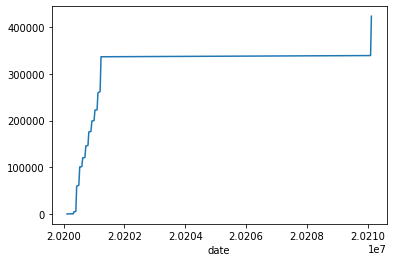

In [26]:
state_data.groupby( 'date' )[ "death" ].sum().plot()

### PANDAS is interpreting the date column as an integer

In [27]:
state_data[ 'date' ]

0        20210128
1        20210128
2        20210128
3        20210128
4        20210128
           ...   
18637    20200117
18638    20200116
18639    20200115
18640    20200114
18641    20200113
Name: date, Length: 18642, dtype: int64

### Use ```pd.to_datetime()``` function to reinterpret dates

Remember ```pd``` is a shortcut for ```pandas``` because we ```import pandas as pd```

In [28]:
state_data[ 'date' ] = pd.to_datetime( state_data[ 'date' ], format="%Y%m%d" )

In [29]:
state_data[ 'date' ]

0       2021-01-28
1       2021-01-28
2       2021-01-28
3       2021-01-28
4       2021-01-28
           ...    
18637   2020-01-17
18638   2020-01-16
18639   2020-01-15
18640   2020-01-14
18641   2020-01-13
Name: date, Length: 18642, dtype: datetime64[ns]

# Quick (non-interactive) plot #1
## Cumulative number of COVID-19 *deaths* in the US

<AxesSubplot:xlabel='date'>

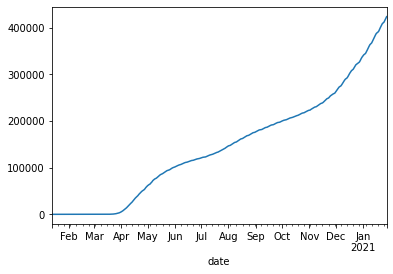

In [30]:
state_data.groupby( 'date' )[ "death" ].sum().plot()

### In this case, the x and y axes were inferred from the structure of the DataFrame

In [31]:
state_data.groupby( 'date' )[ "death" ].sum()

date
2020-01-13         0.0
2020-01-14         0.0
2020-01-15         0.0
2020-01-16         0.0
2020-01-17         0.0
                ...   
2021-01-24    410230.0
2021-01-25    411823.0
2021-01-26    415557.0
2021-01-27    419634.0
2021-01-28    423645.0
Name: death, Length: 382, dtype: float64

# Quick (non-interactive) plot #2
## Daily US COVID-19 *cases* increase

<AxesSubplot:xlabel='date'>

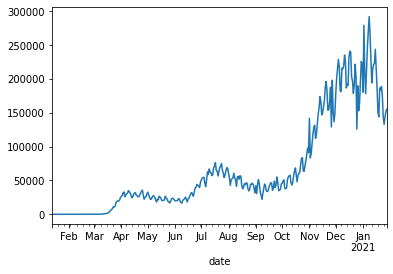

In [32]:
state_data.groupby( 'date' )[ "positiveIncrease" ].sum().plot()

# Interactive plot #1
## Daily US COVID-19 *cases* increase with 7-day rolling average
### Strategy:

1. Construct a new DataFrame with two columns
    1. Raw daily increase
    2. Rolling daily increase
2. Use the ```plot_bokeh()``` function to generate the interactive plot

### Store daily increase in a variable

In [33]:
us_new_cases_daily = state_data.groupby( 'date' )[ "positiveIncrease" ].sum()

In [34]:
us_new_cases_daily

date
2020-01-13         0
2020-01-14         0
2020-01-15         0
2020-01-16         0
2020-01-17         0
               ...  
2021-01-24    143691
2021-01-25    133067
2021-01-26    143745
2021-01-27    151675
2021-01-28    155333
Name: positiveIncrease, Length: 382, dtype: int64

In [35]:
len( us_new_cases_daily)

382

In [36]:
us_new_cases_daily.name = "Daily increase"

### Use the ```rolling()```method to create smooth data series

In [37]:
# can also pass "center=True" argument to rolling()
us_new_cases_7day_mean = us_new_cases_daily.rolling(7).mean()

In [38]:
us_new_cases_7day_mean

date
2020-01-13              NaN
2020-01-14              NaN
2020-01-15              NaN
2020-01-16              NaN
2020-01-17              NaN
                  ...      
2021-01-24    167485.857143
2021-01-25    165035.428571
2021-01-26    164992.285714
2021-01-27    159985.571429
2021-01-28    155885.571429
Name: Daily increase, Length: 382, dtype: float64

### Round the smoothed data to the nearest person

In [39]:
us_new_cases_7day_mean = us_new_cases_daily.rolling(7).mean().fillna(0).round().astype( int )

In [40]:
us_new_cases_7day_mean.name = '7-day average'

In [41]:
us_new_cases_7day_mean

date
2020-01-13         0
2020-01-14         0
2020-01-15         0
2020-01-16         0
2020-01-17         0
               ...  
2021-01-24    167486
2021-01-25    165035
2021-01-26    164992
2021-01-27    159986
2021-01-28    155886
Name: 7-day average, Length: 382, dtype: int64

### Use ```pandas.concat()``` to bind columns together

In [42]:
new_cases_df = pd.concat( ( us_new_cases_daily, us_new_cases_7day_mean ), axis='columns' )

# Comparison of quick plot and interactive plot

In [44]:
new_cases_df.head()

,Daily increase,7-day average
date,,
2020-01-13,0,0
2020-01-14,0,0
2020-01-15,0,0
2020-01-16,0,0
2020-01-17,0,0


In [45]:
new_cases_df.shape

(382, 2)

<AxesSubplot:xlabel='date'>

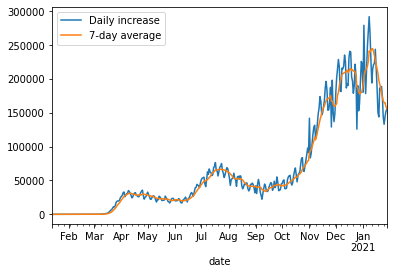

In [43]:
new_cases_df.plot()

In [46]:
new_cases_df.plot_bokeh( legend="top_left" )

Figure(id='1002', ...)

# Saving plot to HTML file

I have been using a somewhat hacky workaround to save plots. I use the ```return_html=True``` argument to grab the raw html, and writing that directly to a file.

In [ ]:
html = new_cases_df.plot_bokeh( legend="top_left", return_html=True )

In [ ]:
with open("/Users/colettace/Desktop/CHRIS_BOKEH_PLOT.html" , "w") as f:
    f.write( '<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">\n' )
    f.write( '<html lang="en">\n' )
    f.write( '  <head>\n' )
    f.write( '    <meta http-equiv="content-type" content="text/html; charset=utf-8">\n' )
    f.write( '    <title>CHRIS\'S BOKEH PLOT</title>\n' )
    f.write( '  </head>\n' )
    f.write( '  <body>\n' )
    f.write( html )
    f.write( '  </body>\n' )
    f.write( '</html>\n' )

# Part 2: Maryland county-level chloropleth map

In [ ]:
us_county_covid_death_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
us_county_covid_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

In [ ]:
us_county_covid_data = pd.read_csv( us_county_covid_url )

In [ ]:
type( us_county_covid_data )

In [ ]:
us_county_covid_data.shape

In [ ]:
us_county_covid_data.head()

In [ ]:
us_county_covid_data.sample(10)

In [ ]:
wanted_rows = us_county_covid_data['Province_State'] == 'Maryland'

In [ ]:
wanted_rows

In [ ]:
maryland_county_covid_data = us_county_covid_data[ wanted_rows ].copy()

In [ ]:
maryland_county_covid_data.shape

In [ ]:
maryland_county_covid_data

## Download US geographic boundaries from www.census.gov

* [US geographic boundaries download page](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html)
    * Manually download and unzip [1:500,000 scale shapefiles](https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_county_500k.zip)
    * Use Python to download the file and unzip it programmatically

In [ ]:
url = 'https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_county_500k.zip'
r = requests.get(url, allow_redirects=True)
open('cb_2019_us_county_500k.zip', 'wb').write(r.content)

In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile('cb_2019_us_county_500k.zip') as myzip:
    myzip.extractall()

In [ ]:
us_county_shapes = gpd.read_file( 'cb_2019_us_county_500k.shp' )

In [ ]:
type( us_county_shapes )

In [ ]:
us_county_shapes.shape

In [ ]:
us_county_shapes.info()

In [ ]:
us_county_shapes.head()

# Join the COVID table and the geography table together

Create a table join key 'FIPS' [Federal Information Processing Standard state code](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code)

In [ ]:
us_county_shapes['FIPS'] = us_county_shapes['STATEFP'] + us_county_shapes['COUNTYFP'] 

In [ ]:
us_county_shapes.head()

## Make sure the FIPS column has the same data type

In [ ]:
us_county_shapes['FIPS'].dtype

In [ ]:
maryland_county_covid_data['FIPS'].dtype

In [ ]:
us_county_shapes['FIPS'] = us_county_shapes['FIPS'].astype( int )

In [ ]:
maryland_county_covid_data['FIPS'] = maryland_county_covid_data['FIPS'].astype( int )

## Perform table merge

* INNER join: resultant output contains only the rows for which the join keys appear in both tables

In [ ]:
merged_data = us_county_shapes.merge( maryland_county_covid_data, on='FIPS', how='inner' ) 

In [ ]:
merged_data

# Chloropleth Map

* Use ```plot_bokeh()```
* IMPORTANT:
    * Chloropleth maps require the data frame object to be a ```GeoDataFrame```
    * A column with label ```'geometry'``` must be in the ```GeoDataFrame```

In [ ]:
type( merged_data )

In [ ]:
'geometry' in merged_data.columns

In [ ]:
merged_data.plot_bokeh()

In [ ]:
date_columns = [ _ for _ in merged_data.columns if _.endswith( '/20' ) ]

In [ ]:
len( date_columns )

In [ ]:
date_columns[-10:]

In [ ]:
merged_data.plot_bokeh(
    #figsize=(1600, 900),
    #figsize=(600, 400),
    slider=date_columns,
    slider_name="Date",
    hovertool_columns= ['NAME'] + date_columns[-5:] )

In [ ]:
gpd.__version__